In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
import seaborn
import statsmodels.api as sm
from scipy.stats import zscore
from statsmodels import regression
from statsmodels.tsa.stattools import coint

import time

In [2]:
data = pd.read_excel('/home/daniel/Desktop/Projetos/mql_python/Relatório 1/dados_relatorio.xlsx')
# tickers = ['close IBOV', 'close ABEV3', 'close B3SA3', 'close BBAS3', 'close BBDC3', 'close BBDC4', 'close BEEF3', 'close BRAP4', 'close BRFS3', 'close BRKM5', 'close BRML3', 'close BTOW3', 'close CCRO3', 'close CIEL3', 'close CMIG4', 'close COGN3', 'close CPFE3', 'close CSAN3', 'close CSNA3', 'close CYRE3', 'close ECOR3', 'close ELET3', 'close ELET6', 'close EMBR3', 'close ENBR3', 'close EQTL3', 'close FLRY3', 'close GGBR4', 'close GOAU4', 'close GOLL4', 'close HGTX3', 'close HYPE3', 'close IGTA3', 'close ITSA4', 'close ITUB4', 'close JBSS3', 'close LAME4', 'close LREN3', 'close MGLU3', 'close MRFG3', 'close MRVE3', 'close MULT3', 'close NTCO3', 'close PETR3', 'close PETR4', 'close QUAL3', 'close RADL3', 'close RAIL3', 'close RENT3', 'close SANB11', 'close SBSP3', 'close SULA11', 'close SUZB3', 'close TIMP3', 'close TOTS3', 'close UGPA3', 'close USIM5', 'close VALE3', 'close VIVT4', 'close WEGE3', 'close YDUQ3']
# dados = data[tickers]

In [3]:
tickers = ['close BBAS3', 'close ITSA4']
dados = data[tickers][:]          

In [4]:
dados

,close BBAS3,close ITSA4
0,14.71,3.82
1,14.64,3.82
2,14.48,3.81
3,14.12,3.83
4,14.23,3.85
...,...,...
1970,50.45,13.37
1971,51.98,13.46
1972,52.57,13.70
1973,52.34,13.64


In [5]:
momentaneo = dados.copy()

In [6]:
# mom = np.log(momentaneo).pct_change()[1:]
mom = momentaneo.pct_change()[1:]
dados = dados[1:]
mom

,close BBAS3,close ITSA4
1,-0.004759,0.000000
2,-0.010929,-0.002618
3,-0.024862,0.005249
4,0.007790,0.005222
5,0.021082,0.015584
...,...,...
1970,-0.001978,-0.008895
1971,0.030327,0.006731
1972,0.011351,0.017831
1973,-0.004375,-0.004380


In [7]:
dados

,close BBAS3,close ITSA4
1,14.64,3.82
2,14.48,3.81
3,14.12,3.83
4,14.23,3.85
5,14.53,3.91
...,...,...
1970,50.45,13.37
1971,51.98,13.46
1972,52.57,13.70
1973,52.34,13.64


In [8]:
def calcula_zscore_spread(s1,s2,t1,t2):
    s1 = sm.add_constant(s1)
    results = sm.OLS(s2,s1).fit()
    s1 = s1[t1]
    b = results.params[t1]
    spread = s2 - (b*s1)
    zs = zscore(spread)[-1]
    return zs

def cria_variaveis(par):
    dic[par] = {}
    dic[par]['Posicionado'] = False
    dic[par]['Saldo Financeiro'] = 100000
    dic[par]['Numero Operacoes'] = 0
    dic[par]['Duracao Operacao'] = []
    dic[par]['Volume'] = 0
    dic[par]['diferenca dias'] = 0
    dic[par]['Razao s1/s2'] = 0
    
    dic[par]['Entrada'] = 0
    dic[par]['Saída'] = 0

    return dic[par]

In [9]:
l_zs = []
l_resultado = []

dic = {}
start = time.process_time()
c = 0
tickers = mom.columns.to_list()
for index in range(90,len(mom)): #todas as linhas dos dados
    for i in range(len(tickers)-1): #todas os tickers 
        for j in range(i+1, len(tickers)): #todas as possibilidades de pares
            t1,t2 = tickers[i], tickers[j]
            s1,s2 = mom[t1][c:index],mom[t2][c:index]
            preco_s1 = dados[t1][dados.index == index].values[0]
            preco_s2 = dados[t2][dados.index == index].values[0]
            
            #cria dados sobre os pares de trade
            par = (t1+' x '+t2)
            print(par)
            if not par in dic:
                cria_variaveis(par)

#             if coint(s1,s2)[1] < 0.01: #checa se sao cointegrados
            zs = calcula_zscore_spread(s1,s2,t1,t2)

            #condicao para se posicionar
            if zs >= 1.1 and dic[par]['Posicionado'] == False:
                carteira = dic[par]['Saldo Financeiro']
                l_zs.append(zs)

                dic[par]['Razao s1/s2'] = preco_s1/preco_s2 
                dic[par]['Volume'] = carteira/2/preco_s1 #volume de acordo com a carteira
                v, q = dic[par]['Volume'], dic[par]['Razao s1/s2'] #razao para posicao ficar igual 

                carteira -= v*preco_s1 #comprou Stock1
                print(f'Comprou: {(v*preco_s1):.2f}, Vendeu:  {(v*preco_s2*q):.2f}')
                carteira += v*preco_s2*q #vendeu Stock2 (recebe o dinheiro)
                
                dic[par]['Entrada'] = -v*preco_s1 + v*preco_s2*q
                dic[par]['Saldo Financeiro'] = carteira
                dic[par]['Posicionado'] = True
                dic[par]['diferenca dias'] = index

            #condicao para encerrar posicao    
            elif (zs > -.08 and zs < .08) and dic[par]['Posicionado'] == True:
                v, q = dic[par]['Volume'], dic[par]['Razao s1/s2'] #razao para posicao ficar igual 
                
                dic[par]['Saldo Financeiro'] += v*preco_s1 #vnedeu Stock1
                print(f'Vendeu:  {(v*preco_s1):.2f}, Comprou: {(v*preco_s2*q):.2f}')

                dic[par]['Saldo Financeiro'] -= v*q*preco_s2 #comprou Stock2
    
                
                print(f'Resultado: {(dic[par]["Entrada"] + v*preco_s1 - v*q*preco_s2):.2f}')
                print(f"{dic[par]['Saldo Financeiro']}\n")
                dic[par]['Posicionado'] = False
                dic[par]['Numero Operacoes'] += 1
                dic[par]['Duracao Operacao'].append(index - dic[par]['diferenca dias'])
                dic[par]['diferenca dias'] = 0
    c+=1
    
print(time.process_time() - start)

close BBAS3 x close ITSA4
Comprou: 50000.00, Vendeu:  50000.00
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
Vendeu:  49096.62, Comprou: 48253.97
Resultado: 842.65
100842.65389842764

close BBAS3 x close ITSA4
Comprou: 50421.33, Vendeu:  50421.33
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
Vendeu:  48025.74, Comprou: 49012.04
Resultado: -986.29
99856.36223836603

close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
Comprou: 49928.18, Vendeu:  49928.18
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3

close BBAS3 x close ITSA4
Comprou: 50848.06, Vendeu:  50848.06
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
Vendeu:  51367.25, Comprou: 48797.74
Resultado: 2569.51
104265.64233906096

close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
Comprou: 52132.82, Vendeu:  52132.82
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
Vendeu:  53386.01,

close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
Vendeu:  50863.38, Comprou: 54614.13
Resultado: -3750.75
99983.13005415993

close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
Comprou: 49991.57, Vendeu:  49991.57
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
Vendeu:  46534.44, Comprou: 48699.54
Resultado: -2165.10
97818.03044500813

close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
Comprou: 48909.02, Vendeu:  48909.02
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
Vendeu:  57519.94, C

close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
Comprou: 48039.43, Vendeu:  48039.43
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
Vendeu:  55648.36, Comprou: 50882.58
Resultado: 4765.78
100844.63827064737

close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
Comprou: 50422.32, Vendeu:  50422.32
close BBAS3 x close ITSA4
Vendeu:  50958.44, Comprou: 50708.81
Resultado: 249.63
101094.27029985936

close BBAS3 x close ITSA4
close BBAS3 x close I

close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
Comprou: 52054.81, Vendeu:  52054.81
close BBAS3 x close ITSA4
Vendeu:  51277.57, Comprou: 51656.84
Resultado: -379.27
103730.35732218168

close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
Comprou: 51865.18, Vendeu:  51865.18
close BBAS3 x close ITSA4
Vendeu:  52403.65, Comprou: 52190.35
Resultado: 213.29
103943.65117468796

close BBAS3 x close ITSA4
Comprou: 51971.83, Vendeu:  51971.83
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
Vendeu:  48360.30, Comprou: 50290.15
Resultado: -1929.85
10201

close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
Comprou: 54075.47, Vendeu:  54075.47
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
c

close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
Comprou: 57375.04, Vendeu:  57375.04
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
Vendeu:  56753.93, Comprou: 58834.50
Resultado: -2080.57
112669.504700494

close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
Comprou: 56334.75, Vendeu:  56334.75
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
Vendeu:  59207.79, Comprou: 59550.00
Resultado: -342.21
112327.29112591053

close BBAS3 x close ITSA4
close BBAS3 x close ITSA4
close BBAS3 x close I

In [10]:
for k,v in dic.items():
    print(k,v['Saldo Financeiro'])
    print('')

close BBAS3 x close ITSA4 112327.29112591053



In [11]:
len(l_zs)

84

In [12]:
l_resultado

[]

In [13]:
contador = 0
for i in range(len(tickers)):
    for j in range(i+1, len(tickers)-1):
        if (coint(mom[tickers[i]],mom[tickers[j]])[1]) > .1:
            print(f'{tickers[i]} and {tickers[j]} nao cointegrated')

In [14]:
mom.columns.to_list()

['close BBAS3', 'close ITSA4']

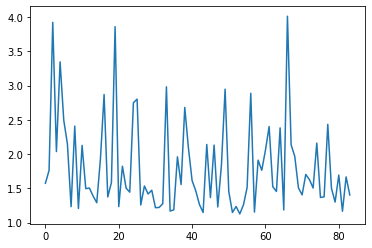

In [15]:
plt.plot(l_zs)

In [16]:
pd.DataFrame(l_zs)

,0
0,1.573583
1,1.763268
2,3.924053
3,2.036785
4,3.346847
...,...
79,1.299467
80,1.693265
81,1.165313
82,1.666682


In [17]:
dic = {}

class Pair_trading():
    def __init__(self, dados, t1, t2, index, posicao_financeira):
        self.t1, self.t2 = t1, t2
        self.par = (t1+' x '+t2)
        self.posicao_financeira = posicao_financeira
        self.index = index
        self.dados = dados 
        
        dic[self.par] = {}

        
    def realiza_operacao(self):
        #apenas financeiro
        self.posicao_financeira -= (dados[t1][dados.index == self.index].values[0]) #comprou
        dic[self.par]['Posicao Financeira'] = self.posicao_financeira
        
        return self.posicao_financeira


In [18]:
banana = Pair_trading(dados,t1,t2,1047,0)
banana.realiza_operacao()

-16.83

In [19]:
dic

{'close BBAS3 x close ITSA4': {'Posicao Financeira': -16.83}}

In [20]:
t1 = 'close IBOV'

In [21]:
banana1 = Pair_trading(dados,t1,t2,1053,0)


In [22]:
banana1.realiza_operacao()

KeyError: 'close IBOV'

In [ ]:
dic={}

In [ ]:
dic['potato'] = 10

In [ ]:
if not (dic['potato']):
    print('oi')

In [ ]:
#Quero saber qual é o par que foi operado, a quantidade de operacões, a duração, e o resultado. 

In [ ]:
mom